In [1]:
import numpy as np
import pandas as pd
from typing import Optional, Dict, Callable, Tuple

In [2]:
from src.cls.backtest import Backtester

## Data

In [3]:
df = pd.read_csv("../data/gold_prices.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [4]:
df

,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,428.700012,431.000000,431.000000,431.000000,4
2005-01-04,428.500000,428.500000,428.500000,428.500000,108
2005-01-05,426.600006,425.700012,425.700012,425.700012,2
2005-01-06,421.000000,421.000000,421.000000,421.000000,1
2005-01-07,418.899994,423.700012,418.700012,423.700012,1
...,...,...,...,...,...
2025-09-24,3732.100098,3772.500000,3732.100098,3769.800049,588
2025-09-25,3736.899902,3756.000000,3724.699951,3742.800049,1899
2025-09-26,3775.300049,3775.300049,3775.300049,3775.300049,19308


## Trigger Function

In [5]:
def prepare_technical_columns(
    df: pd.DataFrame,
    *,
    weekly_rule: str = 'W-FRI',  # kept for compatibility; not used in ATH logic
) -> pd.DataFrame:
    """
    Compute columns for an ATH-drop strategy.

    Adds columns:
      - ath: running all-time high of Close (inclusive)
      - drawdown_from_ath_pct: (ath - Close) / ath
    """
    df = df.copy()

    # Running all-time high of the Close
    df['ath'] = df['Close'].cummax()

    # Drawdown from ATH as a fraction (e.g., 0.05 = 5%)
    with np.errstate(divide='ignore', invalid='ignore'):
        dd = (df['ath'] - df['Close']) / df['ath']
    df['drawdown_from_ath_pct'] = dd.replace([np.inf, -np.inf], np.nan)

    return df


def make_technical_buy_fn(drop_trigger_pct: Optional[float] = 0.05) -> Callable[[pd.DataFrame, int], Tuple[bool, Optional[float]]]:
    """
    Buy when today's Close is at least `drop_trigger_pct` below the latest ATH (all-time high)
    observed up to today.

    Condition:
      - Close[t] <= ATH[t] * (1 - drop_trigger_pct)
    """

    thr = float(drop_trigger_pct) if drop_trigger_pct is not None else None

    def buy_fn(df: pd.DataFrame, i: int, **kwargs) -> Tuple[bool, Optional[float]]:
        if thr is None:
            return False, None
        row = df.iloc[i]
        c = row.get('Close', np.nan)
        ath = row.get('ath', np.nan)
        if not (np.isfinite(c) and np.isfinite(ath) and ath > 0):
            return False, None
        should = c <= ath * (1.0 - thr)
        return bool(should), None  # execute at Close (no specific trigger price)

    return buy_fn


# Backward-compatible alias
def make_technical_trigger(drop_trigger_pct: Optional[float] = 0.05) -> Callable[[pd.DataFrame, int], Tuple[bool, Optional[float]]]:
    """
    Alias for make_technical_buy_fn to preserve backward compatibility.
    """
    return make_technical_buy_fn(drop_trigger_pct)


def make_threshold_sell_fn(
    rise_threshold_pct: float = 0.01,
    sell_pct_of_position: float = 0.10,
) -> Callable[[pd.DataFrame, int], Tuple[bool, Optional[float], Dict]]:
    """
    Placeholder kept for compatibility; for the "No sell" strategy, you can ignore this
    and pass `sell_fn=None` to the Backtester. This function still returns no sell signal.
    """
    def sell_fn(df: pd.DataFrame, i: int, **kwargs) -> Tuple[bool, Optional[float], Dict]:
        return False, None, {}

    return sell_fn

## Backtesting

### Run

In [6]:
buy_fn = make_technical_buy_fn(drop_trigger_pct=0.05)
sell_fn = None  # No sell strategy

In [7]:
bt = Backtester(
    data=df,
    start_fund=10_000,
    target_leverage=5.0,
    fee_pct=0.0002,
    mmr=0.005,
    buy_on_start=True,
    print_daily=False,
    buy_at="trigger",
    buy_fn=buy_fn,
    sell_fn=sell_fn,
    precompute_fn=prepare_technical_columns,
    start_date="2020-01-01",
    end_date=None,
)
bt.run()

In [8]:
print(f"Final Fund Value: {bt.final_fund:,.2f}")
print(f"Max Drawdown Amount: {bt.max_drawdown_amount:,.2f}")
print(f"Max Drawdown Percentage: {bt.max_drawdown_pct:.2f}%")

Final Fund Value: 421,881.49
Max Drawdown Amount: -77,126.50
Max Drawdown Percentage: -86.14%


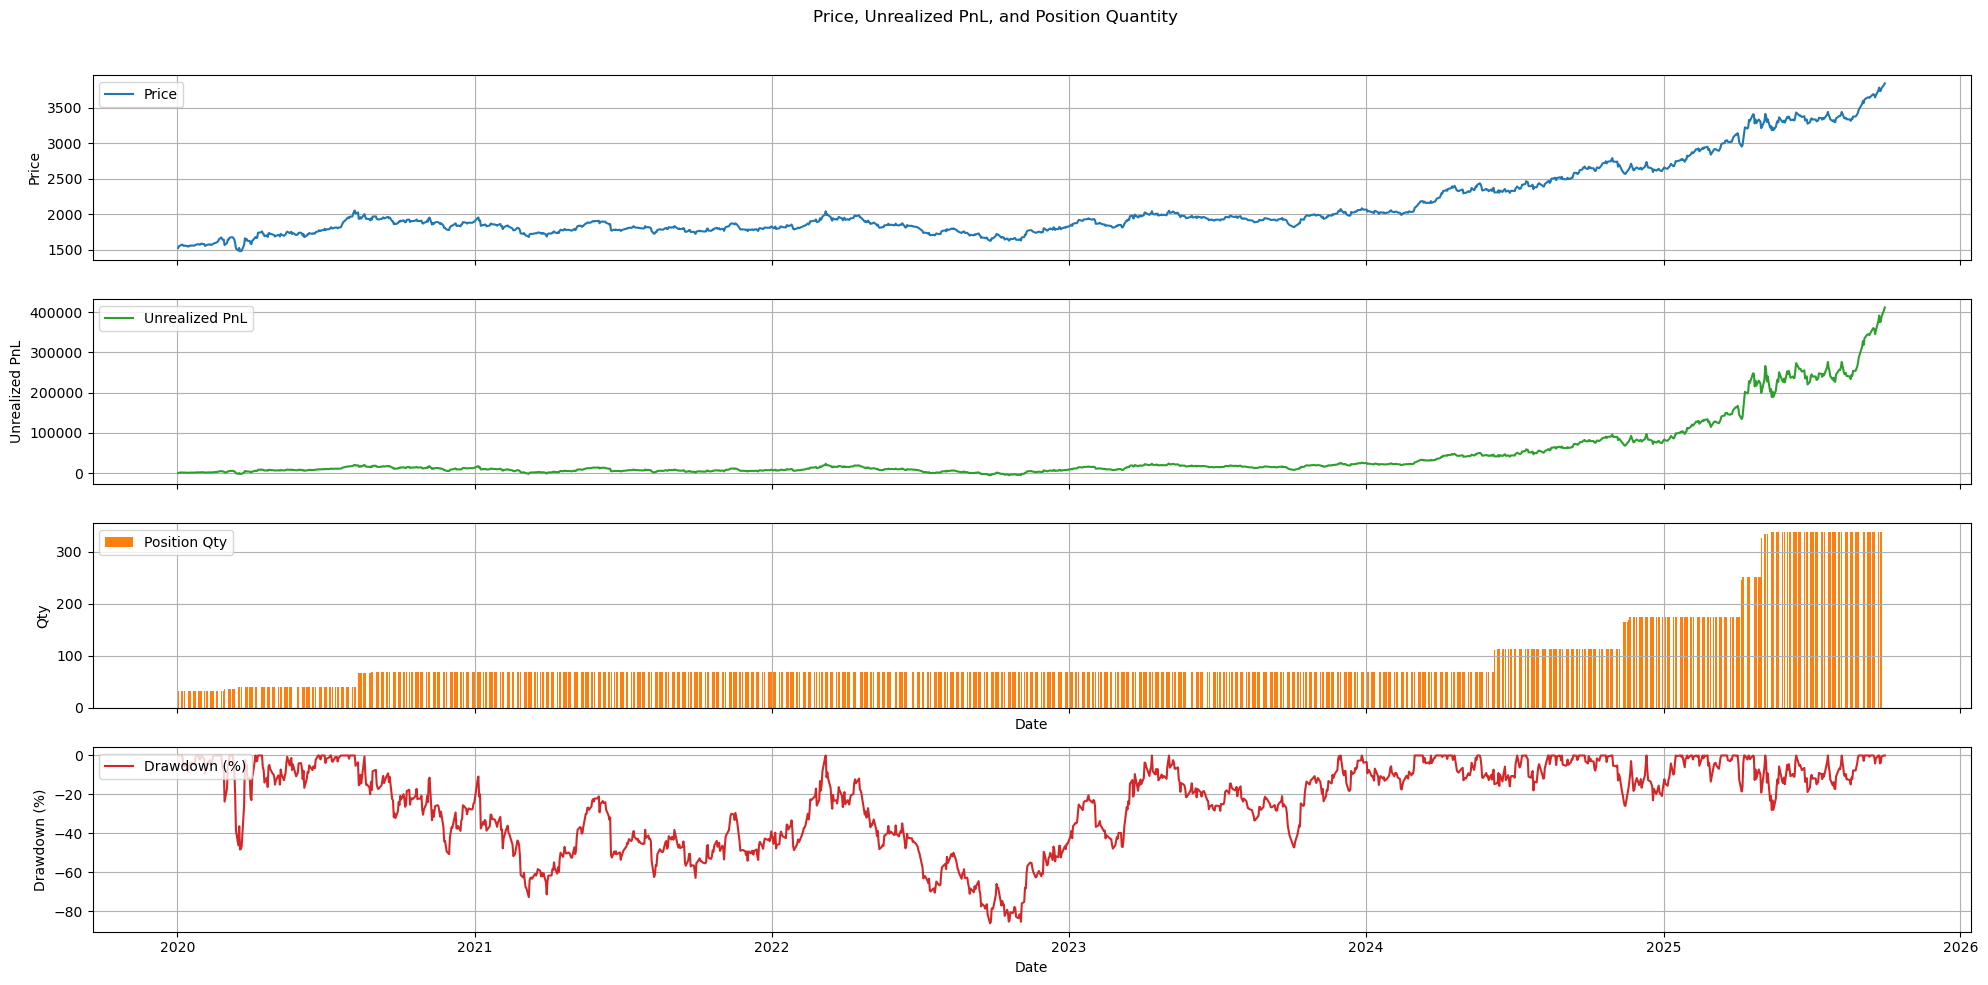

In [9]:
bt.plot_unrealized()

In [10]:
pd.DataFrame(bt.trades)

,date,price,qty,notional,fee_paid,reason
0,2020-01-02,1518.099976,32.935907,50000.000000,10.000000,init-buy
1,2020-02-28,1564.099976,3.842598,6010.206935,1.202041,signal-buy
2,2020-03-12,1589.300049,2.328870,3701.273865,0.740255,signal-buy
3,2020-08-11,1932.599976,27.785644,53698.535098,10.739707,signal-buy
4,2020-08-12,1934.900024,0.290315,561.730309,0.112346,signal-buy
5,2020-08-14,1937.000000,0.291054,563.771717,0.112754,signal-buy
6,2020-08-26,1940.699951,0.514270,998.043998,0.199609,signal-buy
7,2020-09-09,1944.699951,0.558863,1086.820492,0.217364,signal-buy
8,2020-11-05,1945.300049,0.084025,163.454007,0.032691,signal-buy
9,2023-03-22,1946.800049,0.211437,411.625825,0.082325,signal-buy
